## Data preprocessing

In this notebook we can extract the technical indicators as done for the models but here we are simply looking at the relationships between these indicators and the closing price of Ethereum.

### Generator Class
  - Encapsulates various financial technical analysis methods designed to calculate technical indicators from financial data.

**Technical indicators extracted**

- **Simple Moving Average (SMA)**: Calculates the average of the data over a specified window size by creating a constantly updated average price.

- **Exponential Moving Average (EMA)**: Similar to SMA, but gives more weight to recent data, making it more responsive to new information. The windows parameter defines the span of the EMA.

- **Moving Average Convergence Divergence (MACD)**: Calculates the MACD line as the difference between two EMAs (short and long-term), then the signal line as an EMA of the MACD line. Used to identify trend direction and reversals.

- **Relative Strength Index (RSI)**: Momentum oscillator measuring speed and change of price movements. It scillates 0-100, typically used to identify overbought or oversold conditions.

- **Average True Range (ATR)**: Measures market volatility, decomposing the entire range of an asset price for that period. Useful for stop-loss order placement.

- **Bollinger Bands**: Volatility bands are placed above and below a moving average. Volatility is based on the standard deviation and bands automatically widen when volatility increases and narrow when volatility decreases.

- **Raw Stochastic Value (RSV)**: Component of the Stochastic Oscillator, a momentum indicator comparing a particular closing price of an asset to a range of its prices over a certain period. RSV is calculated without the smoothing factors applied in the full Stochastic Oscillator formula.

- **Ichimoku Cloud**: A comprehensive indicator that defines support and resistance, identifies trend direction, gauges momentum, and provides trading signals. The cloud is formed by plotting multiple lines that include leading and lagging spans over a specified period.

- **Volume Weighted Average Price (VWAP)**: Calculates the average price of an asset, weighted by volume, over a specific period. VWAP is often used as a trading benchmark especially by day traders and in algorithmic trading, to ensure trading at a favorable price.


- **Chaikin Money Flow (CMF)**: Measures the volume-weighted average of accumulation and distribution over a specified period. It combines price and volume to show how money may be flowing into or out of a stock. Positive values suggest buying pressure, while negative values indicate selling pressure.

- **On Balance Volume (OBV)**: Uses volume flow to predict changes in stock price. Volume and price are combined to show how money is flowing in or out of a stock. When the price increases, volume adds to the OBV, and when it decreases, volume is subtracted.

- **Commodity Channel Index (CCI)**: Identifies new trends or cyclical conditions. It's typically used to detect when an asset is reaching a condition of being overbought or oversold, by measuring the variation of a commodity price from its statistical mean.

- **Stochastic Oscillator**: A momentum indicator comparing a particular closing price of an asset to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result.

### Libraries of note

**pandas_datareader**: Tool for reading data into pandas DataFrames directly from various internet sources, typically used for fetching financial data.

**yfinance**: Open-source library that uses the Yahoo Finance API to fetch historical market data.

In [ ]:
#!pip install pandas_datareader
#!pip install yfinance
#!pip install xgboost
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
import math

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, TimeDistributed, Reshape, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Attention
from keras.regularizers import l1_l2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from kerastuner.tuners import BayesianOptimization
import seaborn as sns

<ipython-input-2-a5a1a21b3241>:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [ ]:
# Define the Generator class for feature calculations
class Generator:
    def __init__(self):
        pass

    def SMA(self, data, windows):
        return data.rolling(window=windows).mean()

    def EMA(self, data, windows):
        return data.ewm(span=windows).mean()

    def MACD(self, data, long, short, windows):
        short_ema = data.ewm(span=short).mean()
        long_ema = data.ewm(span=long).mean()
        macd = short_ema - long_ema
        signal = macd.ewm(span=windows).mean()
        return signal

    def RSI(self, data, windows):
        delta = data.diff(1)
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        avg_up = up.rolling(window=windows).mean()
        avg_down = down.rolling(window=windows).mean()
        rs = avg_up / avg_down
        rsi = 100.0 - (100.0 / (1.0 + rs))
        return rsi

    def atr(self, data_high, data_low, windows):
        range_ = data_high - data_low
        return range_.rolling(window=windows).mean()

    def bollinger_band(self, data, windows):
        sma = data.rolling(window=windows).mean()
        std = data.rolling(window=windows).std()
        upper_band = sma + 2 * std
        lower_band = sma - 2 * std
        return upper_band, lower_band

    def rsv(self, data, windows):
        min_ = data.rolling(window=windows).min()
        max_ = data.rolling(window=windows).max()
        return (data - min_) / (max_ - min_) * 100

    def ichimoku_cloud(self, data_high, data_low, data_close):
        high_9 = data_high.rolling(window=9).max()
        low_9 = data_low.rolling(window=9).min()
        conversion_line = (high_9 + low_9) / 2
        high_26 = data_high.rolling(window=26).max()
        low_26 = data_low.rolling(window=26).min()
        base_line = (high_26 + low_26) / 2
        leading_span_a = (conversion_line + base_line) / 2
        leading_span_b = (data_high.rolling(window=52).max() + data_low.rolling(window=52).min()) / 2
        return conversion_line, base_line, leading_span_a, leading_span_b

    def vwap(self, data_volume, data_high, data_low, data_close):
        typical_price = (data_high + data_low + data_close) / 3
        vwap = (typical_price * data_volume).cumsum() / data_volume.cumsum()
        return vwap

    def chaikin_money_flow(self, data_high, data_low, data_close, data_volume, windows):
        money_flow_multiplier = ((data_close - data_low) - (data_high - data_close)) / (data_high - data_low)
        money_flow_volume = money_flow_multiplier * data_volume
        return money_flow_volume.rolling(window=windows).sum() / data_volume.rolling(window=windows).sum()

    def on_balance_volume(self, data_close, data_volume):
        return data_volume.where(data_close > data_close.shift(1), -data_volume).cumsum()

    def commodity_channel_index(self, data_high, data_low, data_close, windows):
        typical_price = (data_high + data_low + data_close) / 3
        sma = typical_price.rolling(window=windows).mean()
        mean_deviation = (typical_price - sma).abs().rolling(window=windows).mean()
        cci = (typical_price - sma) / (0.015 * mean_deviation)
        return cci

    def stochastic_oscillator(self, data_high, data_low, data_close, windows):
        low_min = data_low.rolling(window=windows).min()
        high_max = data_high.rolling(window=windows).max()
        k = (data_close - low_min) / (high_max - low_min) * 100
        return k

# Initialize Generator and Yahoo Finance override
gen = Generator()
yf.pdr_override()

### Data Collection

We define the start and end dates for the period over which financial data will be fetched. Yahoo only contains histrorical price data from as far back as November 2017. This is ideal because including data prior to 2018 would be nonsensical due to the price action not being relevant to today.

In [ ]:
# Date range for the data
start = pd.to_datetime('2017-11-11')
end = pd.to_datetime('2024-02-02')

# Crypto tickers, can be combined with other assets by adding to this list.
asset = ["ETH-USD"]

# Fetch and store data
data = pd.DataFrame()
for ticker in asset:
    df = yf.download(ticker, start=start, end=end)
    df['7ma'] = gen.EMA(df['Close'], 7)
    df['14ma'] = gen.EMA(df['Close'], 14)
    df['21ma'] = gen.EMA(df['Close'], 21)
    df['7macd'] = gen.MACD(df['Close'], 26, 12, 9)
    df['14macd'] = gen.MACD(df['Close'], 26, 12, 9)
    df['7rsi'] = gen.RSI(df['Close'], 7)
    df['14rsi'] = gen.RSI(df['Close'], 14)
    df['21rsi'] = gen.RSI(df['Close'], 21)
    df['7atr'] = gen.atr(df['High'], df['Low'], 7)
    df['14atr'] = gen.atr(df['High'], df['Low'], 14)
    df['21atr'] = gen.atr(df['High'], df['Low'], 21)
    df['7upper'], df['7lower'] = gen.bollinger_band(df['Close'], 7)
    df['14upper'], df['14lower'] = gen.bollinger_band(df['Close'], 14)
    df['21upper'], df['21lower'] = gen.bollinger_band(df['Close'], 21)
    df['7rsv'] = gen.rsv(df['Close'], 7)
    df['14rsv'] = gen.rsv(df['Close'], 14)
    df['21rsv'] = gen.rsv(df['Close'], 21)
    df['ichimoku_a'], df['ichimoku_b'], df['lead_span_a'], df['lead_span_b'] = gen.ichimoku_cloud(df['High'], df['Low'], df['Close'])
    df['vwap'] = gen.vwap(df['Volume'], df['High'], df['Low'], df['Close'])
    df['cmf'] = gen.chaikin_money_flow(df['High'], df['Low'], df['Close'], df['Volume'], 21)
    df['obv'] = gen.on_balance_volume(df['Close'], df['Volume'])
    df['cci'] = gen.commodity_channel_index(df['High'], df['Low'], df['Close'], 14)
    df['stochastic'] = gen.stochastic_oscillator(df['High'], df['Low'], df['Close'], 14)

    # Rename columns to include ticker name
    df.rename(columns=lambda x: f"{x}_{ticker}", inplace=True)
    if data.empty:
        data = df
    else:
        data = data.join(df, how='outer')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Dropping NaN values to clean up the dataset
data = data.dropna()

In [ ]:
data.head()

,Open_ETH-USD,High_ETH-USD,Low_ETH-USD,Close_ETH-USD,Adj Close_ETH-USD,Volume_ETH-USD,7ma_ETH-USD,14ma_ETH-USD,21ma_ETH-USD,7macd_ETH-USD,...,21rsv_ETH-USD,ichimoku_a_ETH-USD,ichimoku_b_ETH-USD,lead_span_a_ETH-USD,lead_span_b_ETH-USD,vwap_ETH-USD,cmf_ETH-USD,obv_ETH-USD,cci_ETH-USD,stochastic_ETH-USD
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,751.710506,734.906693,708.693695,59.805841,...,69.108046,702.087494,648.177490,675.132492,590.067978,609.523669,0.244660,24759511744,14.183425,67.679239
2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,784.893880,754.855137,724.773908,59.462030,...,100.000000,800.030518,668.598511,734.314514,606.671509,622.153204,0.220244,30542861504,139.811334,91.811192
2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,829.350410,782.582664,746.531963,61.447777,...,100.000000,829.851013,701.992508,765.921761,640.748001,635.607182,0.250871,35636021440,237.514605,97.271699
2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,867.243312,809.038010,767.953453,64.935273,...,100.000000,865.155487,737.296982,801.226234,680.921478,654.077608,0.229927,42138881216,282.609241,87.202142
2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,899.862480,834.203933,788.942243,69.297229,...,100.000000,880.310516,757.247009,818.778763,699.498001,672.129585,0.164653,48822031040,215.990586,83.132369


In [ ]:
# Calculate correlation matrix for each ticker
correlations = {}
for ticker in asset:
    relevant_columns = [col for col in data.columns if ticker in col or 'Close' in col]
    ticker_data = data[relevant_columns]
    correlations[ticker] = ticker_data.corr()[f'Close_{ticker}']

# Print correlation results for Ethereum
print("Correlation of each indicator with Ethereum's closing price:")
print(correlations['ETH-USD'])

Correlation of each indicator with Ethereum's closing price:
Open_ETH-USD           0.997748
High_ETH-USD           0.998842
Low_ETH-USD            0.998847
Close_ETH-USD          1.000000
Adj Close_ETH-USD      1.000000
Volume_ETH-USD         0.459339
7ma_ETH-USD            0.997292
14ma_ETH-USD           0.993668
21ma_ETH-USD           0.990034
7macd_ETH-USD          0.223913
14macd_ETH-USD         0.223913
7rsi_ETH-USD           0.073641
14rsi_ETH-USD          0.101106
21rsi_ETH-USD          0.116154
7atr_ETH-USD           0.791233
14atr_ETH-USD          0.808976
21atr_ETH-USD          0.820706
7upper_ETH-USD         0.992315
7lower_ETH-USD         0.993657
14upper_ETH-USD        0.985838
14lower_ETH-USD        0.985277
21upper_ETH-USD        0.981115
21lower_ETH-USD        0.975808
7rsv_ETH-USD           0.068751
14rsv_ETH-USD          0.070877
21rsv_ETH-USD          0.082716
ichimoku_a_ETH-USD     0.995129
ichimoku_b_ETH-USD     0.985783
lead_span_a_ETH-USD    0.992169
lead_span_b

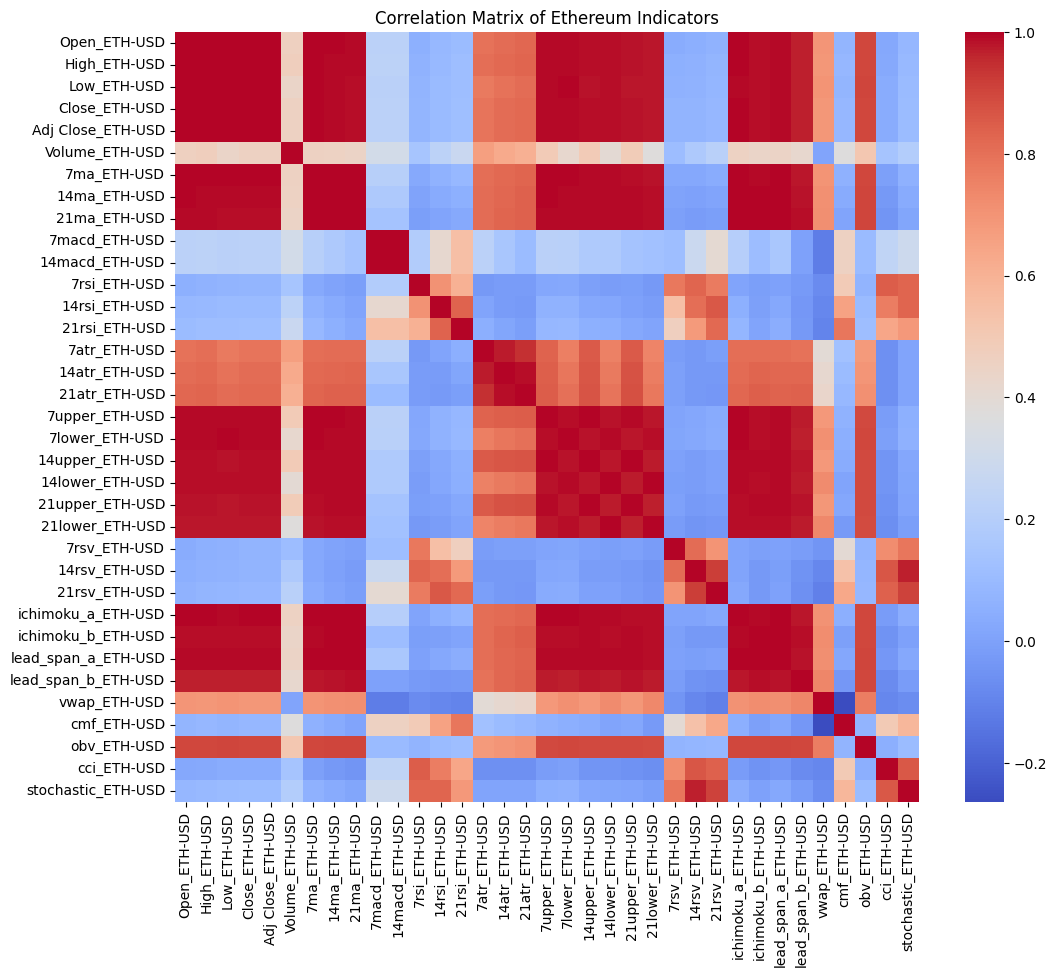

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Ethereum Indicators')
plt.show()

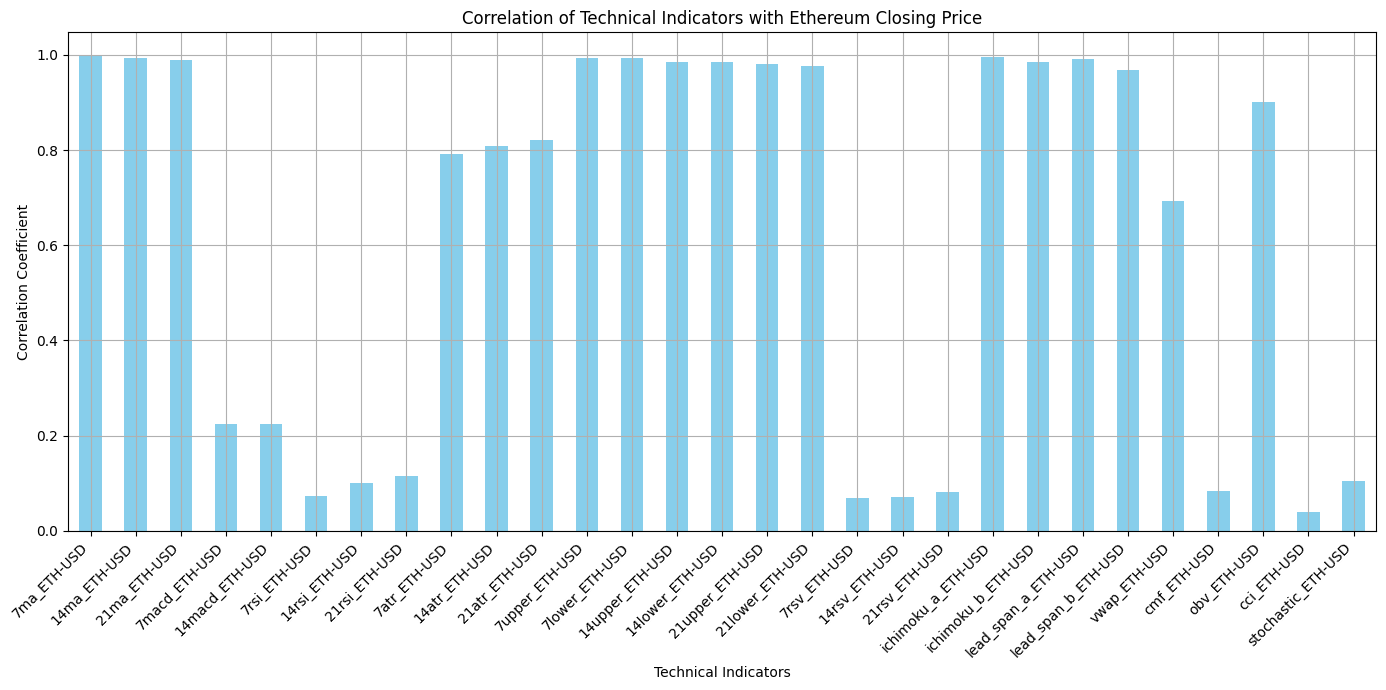

In [ ]:
# Calculate correlation matrix for each ticker
correlations = {}
for ticker in asset:
    relevant_columns = [col for col in data.columns if ticker in col and not col.startswith(('High', 'Low', 'Open', 'Volume', 'Adj Close'))]
    ticker_data = data[relevant_columns]
    correlations[ticker] = ticker_data.corr()[f'Close_{ticker}']

# Extracting correlation results for Ethereum, excluding basic market data columns
eth_correlations = correlations['ETH-USD'].drop(f'Close_{ticker}')


plt.figure(figsize=(14, 7))
ax = eth_correlations.plot(kind='bar', color='skyblue')
plt.title('Correlation of Technical Indicators with Ethereum Closing Price')
plt.xlabel('Technical Indicators')
plt.ylabel('Correlation Coefficient')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()